## Implementation of Twin Neural Networks for classification
##### Himanshu Pant, Jayadeva,Mayank Sharma, Sumit Soman
###### Department of Electrical Engineering, Indian Institute of Technology, Delhi, India

### Paper Abstract:
Twin Support Vector Machines (TWSVMs) have emerged as an efficient alternative to Support Vector Machines (SVM) for learning
from imbalanced datasets. The TWSVM learns two non-parallel classifying hyperplanes by solving a couple of smaller sized
problems. However, it is unsuitable for large datasets, as it involves matrix operations. In this paper, we discuss a Twin Neural Network (Twin NN) architecture for learning from large unbalanced datasets. The objective functions of the networks in the Twin NN are designed to realize the idea of the Twin SVM with non-parallel decision boudaries for the respective classes, while also being able to reduce model complexity. The Twin NN optimizes the feature map, allowing for better discrimination between classes. The paper also discusses an extension of the Twin NN for multiclass datasets. This architecture trains as many neural networks as the number of classes, and has the additional advantage that it does not have any hyper-parameter which requires tuning. Results presented in the paper demonstrate that the Twin NN generalizes well and scales well on large unbalanced datasets.

###### An initial version of this manuscript is available on arXiv : https://arxiv.org/abs/1705.00347





###### Code author: Himanshu Pant
###### Code Version: 1.0.0
###### Code metadata:

{
  "anaconda-cloud": {},
  "kernelspec": {
    "name": "python3",
    "display_name": "Python 3",
    "language": "python"
  },
  "language_info": {
    "name": "python",
    "version": "3.6.5",
    "mimetype": "text/x-python",
    "codemirror_mode": {
      "name": "ipython",
      "version": 3
    },
    "pygments_lexer": "ipython3",
    "nbconvert_exporter": "python",
    "file_extension": ".py"
  }
}


In [2]:
#initialize weights of neural network models.
import numpy as np
def make_network(n_hidden,n_planes,n_feature):
    # Initialize weights with Standard Normal random variables
    rng = np.random.RandomState(1234)
    model = dict(
        W1= np.asarray(
            rng.uniform(
                low=-np.sqrt(6. / (n_feature + n_hidden)),
                high=np.sqrt(6. / (n_feature + n_hidden)),
                size=(n_feature, n_hidden))),
         W2=np.asarray(
            rng.uniform(
                low=-np.sqrt(6. / (n_hidden + n_planes)),
                high=np.sqrt(6. / (n_hidden + n_planes)),
                size=(n_hidden, n_planes))),
        b1 = np.zeros(n_hidden,),
        b2=  np.zeros(n_planes,) 
       
    )

    return model

In [3]:
#function gives prediction error in percentage.
import numpy as np
from numpy import linalg as LA

def getPredictionError(X,Y,model):
    y_pred = np.zeros_like(Y)
    for i, x in enumerate(X):
        y = np.ones((n_models,))
        for index, indmodel in enumerate(model, start=0): 
            oop,iop,hop = forward(x, indmodel)
            val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))
            y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()
        y_pred[i] = y.argmin()
    
    
    err= (1-((y_pred == Y).sum() / Y.size))*100
    return err,y_pred

In [4]:
# forward pass on network oop: output of output layer, x:input data
import numpy as np
def forward(x, model):
    # Input to hidden
    h = x @ model['W1'] + model['b1']
    # taansig non-linearity
    hop=(1-np.exp(-h ))/(1+np.exp(-h ))
    

    # Hidden to output
    iop = hop @ model['W2']+ model['b2']
    oop=(1-np.exp(-iop ))/(1+np.exp(-iop ))
    return oop,iop,hop

In [7]:
#plot confusion matrix-----------------------------------------
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,nclasses,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    classes=range(nclasses)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [6]:
#calculate gradient and update weights as per Twin Neural Nnetwork Objective function and update rules
# Backprop using the information we get from the current minibatch
import numpy as np

def get_minibatch_grad(models, X_train, y_train,n_planes,n_models,n_hidden,lr):
    xs, hs, errs = [], [], []
    Err = np.zeros([n_planes*n_models,y_train.shape[0]])
    err_tot=np.zeros([n_planes*n_models,y_train.shape[0]])
    oops=np.zeros([n_planes*n_models,y_train.shape[0]])
    iops=np.zeros([n_planes*n_models,y_train.shape[0]])
    hops=np.zeros([n_hidden*n_models,y_train.shape[0]])
    ycount=0
    for x, cls_idx in zip(X_train, y_train):
        minIndex=-1
        minModel=-1
        minVals=100000
        for index, model in enumerate(models, start=0):   # default is zero
            
            oop,iop,hop= forward(x, model)
            error=np.zeros(oop.shape[0],)
            indexmin=np.absolute(oop).argmin()
            minVal=np.amin(np.absolute(oop))
            oops[index*n_planes:index*n_planes+n_planes,ycount]=oop
            iops[index*n_planes:index*n_planes+n_planes,ycount]=iop
            hops[index*n_hidden:index*n_hidden+n_hidden,ycount]=hop
            if index==cls_idx: 
                Err[((index*n_planes)+indexmin),ycount]=iop[indexmin] 
                err_tot[((index*n_planes)+indexmin),ycount]=iop[indexmin]*iop[indexmin]
            else:
                if minVal<minVals:
                    minModel= index
                    minIndex=indexmin
                    minVals=minVal
        
        Err[((minModel*n_planes)+minIndex),ycount]=-(1-minVals)*(1-oops[((minModel*n_planes)+minIndex),ycount]*
                                                                oops[((minModel*n_planes)+minIndex),ycount])
        err_tot[((minModel*n_planes)+minIndex),ycount]=(1-minVals)*(1-minVals)
        ycount=ycount+1
        #calculate gradient for each model
    for index, model in enumerate(models, start=0):
        dw2=np.dot(hops[index*n_hidden:index*n_hidden+n_hidden,:],np.transpose(Err[index*n_planes:index*n_planes+n_planes,:]))
        db2=Err[index*n_planes:index*n_planes+n_planes,:]
        gradw1hop=np.dot(model['W2'],Err[index*n_planes:index*n_planes+n_planes,:]) 
        gradw1=gradw1hop*(1-hops[index*n_hidden:index*n_hidden+n_hidden,:]* hops[index*n_hidden:index*n_hidden+n_hidden,:])
        dw1=np.dot(gradw1,X_train)
        db1=gradw1
        model['W2'] -= lr * dw2
        model['W1'] -= lr * np.transpose(dw1)
        model['b2'] -= lr * np.sum(db2, axis=1)
        model['b1'] -= lr * np.sum(db1, axis=1)
    
    errorVal=err_tot.sum().sum()/X_train.shape[0]

    
    return models,errorVal

In [17]:
#prepare mini batches and evaluate errors
from sklearn.utils import shuffle
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


def sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr,samples_eval):
    
    bestValError=101
    bestTestError=101
    bestfscore=0
    for iter in range(n_iter):
        # Randomize data point
        X_train, y_train = shuffle(X_train, y_train)
        for i in range(0, X_train.shape[0], minibatch_size):
            # Get pair of (X, y) of the current minibatch/chunk
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]

            model,errval = get_minibatch_grad(model, X_train_mini, y_train_mini,n_planes,n_models,n_hidden,lr)
            if i%samples_eval==0:
                #get val error
                valError,valpred=getPredictionError(X_Val,y_Val,model)
                print('Evaluating: epoch %i, minibatch %i %%' %(iter+1,i))
                if valError<bestValError:
                    bestValError=valError
                    #if val error is best then calculate test error
                    testError,testpred=getPredictionError(X_test,y_test,model)
                    if n_classes==2:
                        fscore=f1_score(y_test, testpred)
                        if fscore>bestfscore:
                            bestfscore=fscore
                    if testError<bestTestError:
                        bestTestError=testError
                        cnf_matrix = confusion_matrix(y_test, testpred)
                        #print(cnf_matrix)
                        plt.figure()
                        plot_confusion_matrix(cnf_matrix,n_classes, normalize=False,title='confusion matrix')
                        plt.show()
                    
                    if n_classes==2:
                         print('epoch %i, minibatch %i, OB_Fun error %f,fscore %f,test error %f,Bestfscore error %f,Besttest error %f  %%' %
                      (iter+1,
                        i,
                        errval,
                       fscore,
                       testError,
                       bestfscore,
                       bestTestError
                       )
                     )
                    else:
                        print('epoch %i, minibatch %i, OB_Fun error %f,test error %f,Best test error %f  %%' %
                      (iter+1,
                        i,
                        errval,
                       testError,
                       bestTestError
                       )
                     )
    return model

Evaluating: epoch 1, minibatch 0 %
Confusion matrix, without normalization


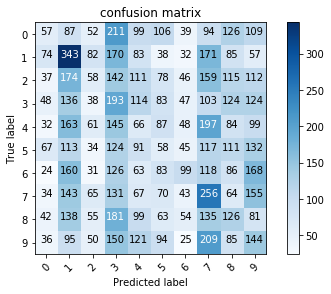

epoch 1, minibatch 0, OB_Fun error 0.962418,test error 86.000000,Best test error 86.000000  %
Evaluating: epoch 1, minibatch 8000 %
Confusion matrix, without normalization


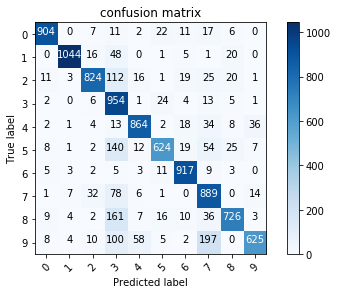

epoch 1, minibatch 8000, OB_Fun error 0.745051,test error 16.290000,Best test error 16.290000  %
Evaluating: epoch 1, minibatch 16000 %
Confusion matrix, without normalization


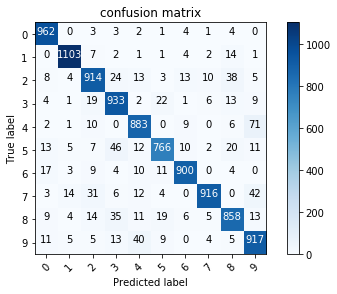

epoch 1, minibatch 16000, OB_Fun error 0.687039,test error 8.480000,Best test error 8.480000  %
Evaluating: epoch 1, minibatch 24000 %
Confusion matrix, without normalization


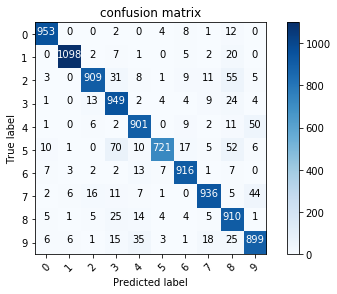

epoch 1, minibatch 24000, OB_Fun error 0.526176,test error 8.080000,Best test error 8.080000  %
Evaluating: epoch 1, minibatch 32000 %
Evaluating: epoch 1, minibatch 40000 %
Confusion matrix, without normalization


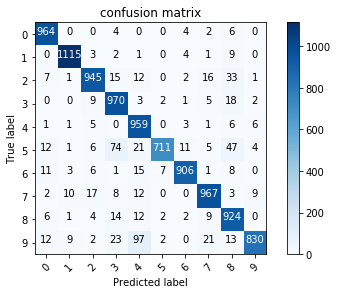

epoch 1, minibatch 40000, OB_Fun error 0.344846,test error 7.090000,Best test error 7.090000  %
Evaluating: epoch 1, minibatch 48000 %
Confusion matrix, without normalization


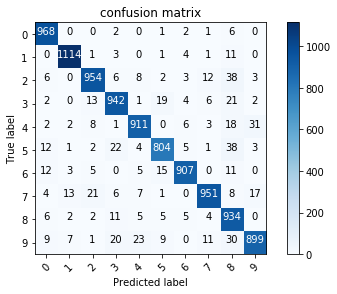

epoch 1, minibatch 48000, OB_Fun error 0.277100,test error 6.160000,Best test error 6.160000  %
Evaluating: epoch 2, minibatch 0 %
Evaluating: epoch 2, minibatch 8000 %
Evaluating: epoch 2, minibatch 16000 %
Confusion matrix, without normalization


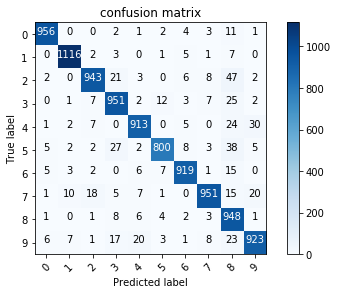

epoch 2, minibatch 16000, OB_Fun error 0.402521,test error 5.800000,Best test error 5.800000  %
Evaluating: epoch 2, minibatch 24000 %
Confusion matrix, without normalization


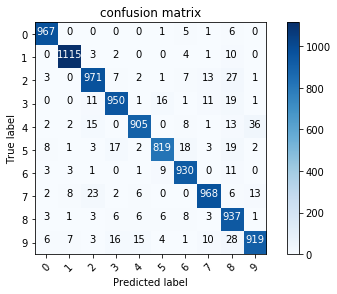

epoch 2, minibatch 24000, OB_Fun error 0.240301,test error 5.190000,Best test error 5.190000  %
Evaluating: epoch 2, minibatch 32000 %
Evaluating: epoch 2, minibatch 40000 %
Evaluating: epoch 2, minibatch 48000 %
Confusion matrix, without normalization


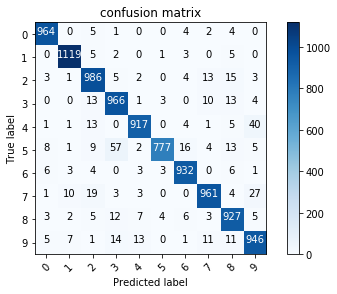

epoch 2, minibatch 48000, OB_Fun error 0.431218,test error 5.050000,Best test error 5.050000  %
Evaluating: epoch 3, minibatch 0 %
Evaluating: epoch 3, minibatch 8000 %
Confusion matrix, without normalization


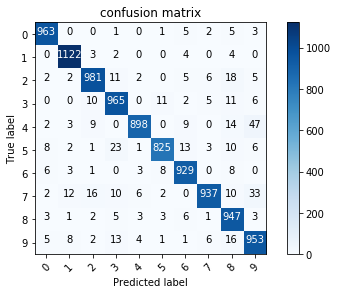

epoch 3, minibatch 8000, OB_Fun error 0.308251,test error 4.800000,Best test error 4.800000  %
Evaluating: epoch 3, minibatch 16000 %
Confusion matrix, without normalization


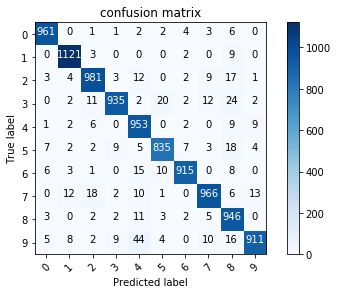

epoch 3, minibatch 16000, OB_Fun error 0.233275,test error 4.760000,Best test error 4.760000  %
Evaluating: epoch 3, minibatch 24000 %
Confusion matrix, without normalization


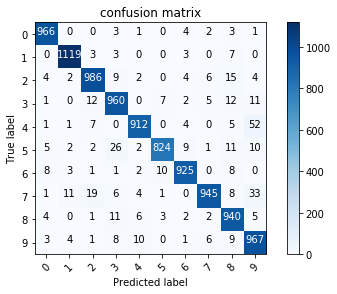

epoch 3, minibatch 24000, OB_Fun error 0.352849,test error 4.560000,Best test error 4.560000  %
Evaluating: epoch 3, minibatch 32000 %
Confusion matrix, without normalization


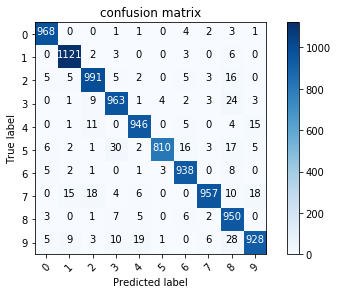

epoch 3, minibatch 32000, OB_Fun error 0.252968,test error 4.280000,Best test error 4.280000  %
Evaluating: epoch 3, minibatch 40000 %
Evaluating: epoch 3, minibatch 48000 %
Confusion matrix, without normalization


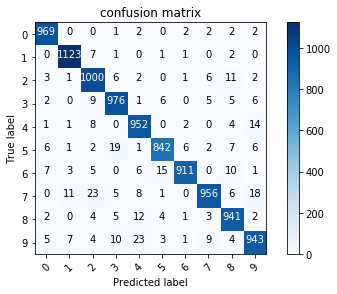

epoch 3, minibatch 48000, OB_Fun error 0.351566,test error 3.870000,Best test error 3.870000  %
Evaluating: epoch 4, minibatch 0 %
Evaluating: epoch 4, minibatch 8000 %
Confusion matrix, without normalization


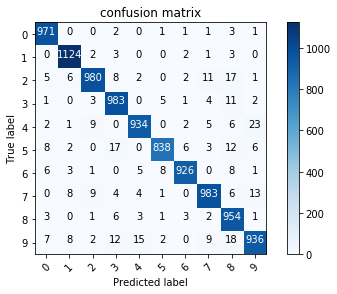

epoch 4, minibatch 8000, OB_Fun error 0.183292,test error 3.710000,Best test error 3.710000  %
Evaluating: epoch 4, minibatch 16000 %
Evaluating: epoch 4, minibatch 24000 %
Evaluating: epoch 4, minibatch 32000 %
Evaluating: epoch 4, minibatch 40000 %
Evaluating: epoch 4, minibatch 48000 %
Confusion matrix, without normalization


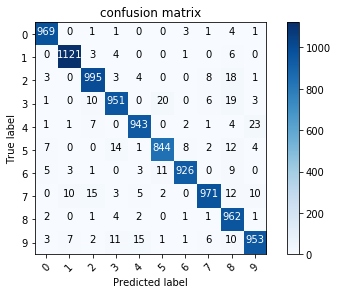

epoch 4, minibatch 48000, OB_Fun error 0.260611,test error 3.650000,Best test error 3.650000  %
Evaluating: epoch 5, minibatch 0 %
Evaluating: epoch 5, minibatch 8000 %
Evaluating: epoch 5, minibatch 16000 %
Confusion matrix, without normalization


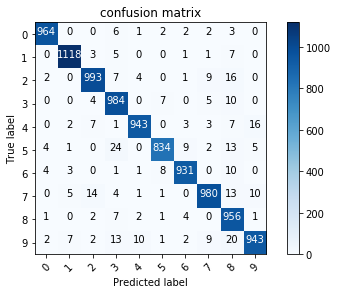

epoch 5, minibatch 16000, OB_Fun error 0.183764,test error 3.540000,Best test error 3.540000  %
Evaluating: epoch 5, minibatch 24000 %
Evaluating: epoch 5, minibatch 32000 %
Confusion matrix, without normalization


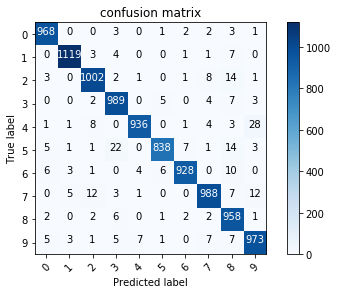

epoch 5, minibatch 32000, OB_Fun error 0.185498,test error 3.010000,Best test error 3.010000  %
Evaluating: epoch 5, minibatch 40000 %
Evaluating: epoch 5, minibatch 48000 %
Evaluating: epoch 6, minibatch 0 %
Evaluating: epoch 6, minibatch 8000 %
Evaluating: epoch 6, minibatch 16000 %
epoch 6, minibatch 16000, OB_Fun error 0.194712,test error 3.200000,Best test error 3.010000  %
Evaluating: epoch 6, minibatch 24000 %
Evaluating: epoch 6, minibatch 32000 %
Evaluating: epoch 6, minibatch 40000 %
Evaluating: epoch 6, minibatch 48000 %
Evaluating: epoch 7, minibatch 0 %
Evaluating: epoch 7, minibatch 8000 %
Evaluating: epoch 7, minibatch 16000 %
Evaluating: epoch 7, minibatch 24000 %
Evaluating: epoch 7, minibatch 32000 %
epoch 7, minibatch 32000, OB_Fun error 0.181638,test error 3.050000,Best test error 3.010000  %
Evaluating: epoch 7, minibatch 40000 %
Evaluating: epoch 7, minibatch 48000 %
Evaluating: epoch 8, minibatch 0 %
Evaluating: epoch 8, minibatch 8000 %
Evaluating: epoch 8, mini

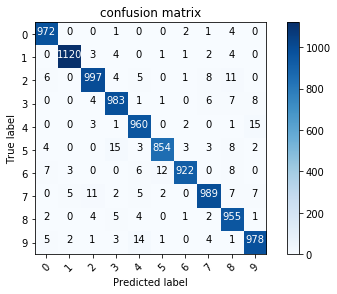

epoch 8, minibatch 48000, OB_Fun error 0.153195,test error 2.700000,Best test error 2.700000  %
Evaluating: epoch 9, minibatch 0 %
Evaluating: epoch 9, minibatch 8000 %
Evaluating: epoch 9, minibatch 16000 %
Evaluating: epoch 9, minibatch 24000 %
Confusion matrix, without normalization


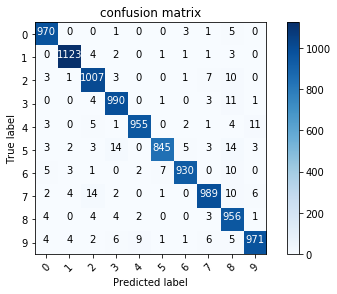

epoch 9, minibatch 24000, OB_Fun error 0.130481,test error 2.640000,Best test error 2.640000  %
Evaluating: epoch 9, minibatch 32000 %
Evaluating: epoch 9, minibatch 40000 %
Evaluating: epoch 9, minibatch 48000 %
Confusion matrix, without normalization


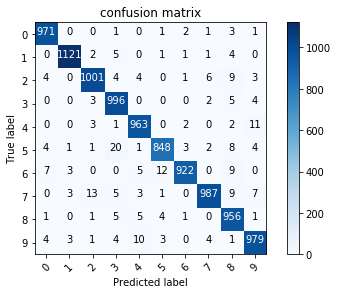

epoch 9, minibatch 48000, OB_Fun error 0.069034,test error 2.560000,Best test error 2.560000  %
Evaluating: epoch 10, minibatch 0 %
Evaluating: epoch 10, minibatch 8000 %
Evaluating: epoch 10, minibatch 16000 %
Evaluating: epoch 10, minibatch 24000 %
Evaluating: epoch 10, minibatch 32000 %
Evaluating: epoch 10, minibatch 40000 %
Evaluating: epoch 10, minibatch 48000 %
Evaluating: epoch 11, minibatch 0 %
Evaluating: epoch 11, minibatch 8000 %
Evaluating: epoch 11, minibatch 16000 %
Evaluating: epoch 11, minibatch 24000 %
Evaluating: epoch 11, minibatch 32000 %
Evaluating: epoch 11, minibatch 40000 %
Evaluating: epoch 11, minibatch 48000 %
Confusion matrix, without normalization


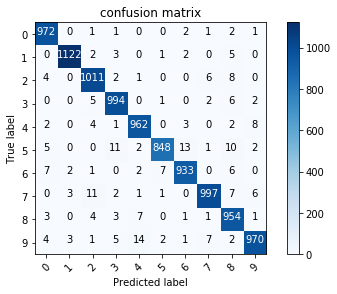

epoch 11, minibatch 48000, OB_Fun error 0.071259,test error 2.370000,Best test error 2.370000  %
Evaluating: epoch 12, minibatch 0 %
Evaluating: epoch 12, minibatch 8000 %
epoch 12, minibatch 8000, OB_Fun error 0.074613,test error 2.370000,Best test error 2.370000  %
Evaluating: epoch 12, minibatch 16000 %
Evaluating: epoch 12, minibatch 24000 %
Evaluating: epoch 12, minibatch 32000 %
epoch 12, minibatch 32000, OB_Fun error 0.079923,test error 2.410000,Best test error 2.370000  %
Evaluating: epoch 12, minibatch 40000 %
Evaluating: epoch 12, minibatch 48000 %
Evaluating: epoch 13, minibatch 0 %
Evaluating: epoch 13, minibatch 8000 %
Evaluating: epoch 13, minibatch 16000 %
Evaluating: epoch 13, minibatch 24000 %
Evaluating: epoch 13, minibatch 32000 %
Evaluating: epoch 13, minibatch 40000 %
Evaluating: epoch 13, minibatch 48000 %
Evaluating: epoch 14, minibatch 0 %
Evaluating: epoch 14, minibatch 8000 %
Evaluating: epoch 14, minibatch 16000 %
Evaluating: epoch 14, minibatch 24000 %
Evalu

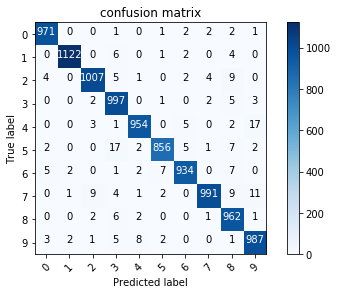

epoch 15, minibatch 32000, OB_Fun error 0.072181,test error 2.190000,Best test error 2.190000  %
Evaluating: epoch 15, minibatch 40000 %
Evaluating: epoch 15, minibatch 48000 %
Evaluating: epoch 16, minibatch 0 %
Evaluating: epoch 16, minibatch 8000 %
epoch 16, minibatch 8000, OB_Fun error 0.081974,test error 2.240000,Best test error 2.190000  %
Evaluating: epoch 16, minibatch 16000 %
Evaluating: epoch 16, minibatch 24000 %
Evaluating: epoch 16, minibatch 32000 %
Evaluating: epoch 16, minibatch 40000 %
Evaluating: epoch 16, minibatch 48000 %
Evaluating: epoch 17, minibatch 0 %
Evaluating: epoch 17, minibatch 8000 %
Evaluating: epoch 17, minibatch 16000 %
Evaluating: epoch 17, minibatch 24000 %
Evaluating: epoch 17, minibatch 32000 %
Evaluating: epoch 17, minibatch 40000 %
epoch 17, minibatch 40000, OB_Fun error 0.102004,test error 2.210000,Best test error 2.190000  %
Evaluating: epoch 17, minibatch 48000 %
Evaluating: epoch 18, minibatch 0 %
Evaluating: epoch 18, minibatch 8000 %
Evalu

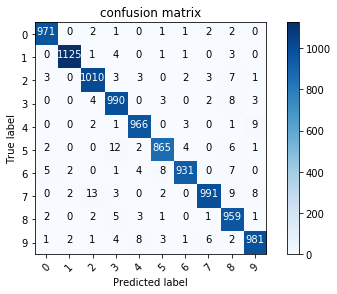

epoch 19, minibatch 8000, OB_Fun error 0.056895,test error 2.110000,Best test error 2.110000  %
Evaluating: epoch 19, minibatch 16000 %
Evaluating: epoch 19, minibatch 24000 %
Evaluating: epoch 19, minibatch 32000 %
Evaluating: epoch 19, minibatch 40000 %
Evaluating: epoch 19, minibatch 48000 %
Evaluating: epoch 20, minibatch 0 %
Evaluating: epoch 20, minibatch 8000 %
Evaluating: epoch 20, minibatch 16000 %
Evaluating: epoch 20, minibatch 24000 %
Evaluating: epoch 20, minibatch 32000 %
epoch 20, minibatch 32000, OB_Fun error 0.109873,test error 2.110000,Best test error 2.110000  %
Evaluating: epoch 20, minibatch 40000 %
Evaluating: epoch 20, minibatch 48000 %
Evaluating: epoch 21, minibatch 0 %
Evaluating: epoch 21, minibatch 8000 %
Evaluating: epoch 21, minibatch 16000 %
Evaluating: epoch 21, minibatch 24000 %
Evaluating: epoch 21, minibatch 32000 %
Evaluating: epoch 21, minibatch 40000 %
Evaluating: epoch 21, minibatch 48000 %
Evaluating: epoch 22, minibatch 0 %
Evaluating: epoch 22,

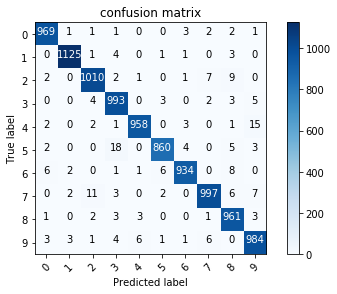

epoch 22, minibatch 32000, OB_Fun error 0.049337,test error 2.090000,Best test error 2.090000  %
Evaluating: epoch 22, minibatch 40000 %
Confusion matrix, without normalization


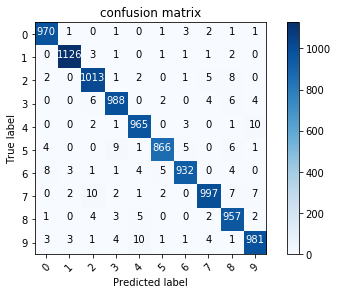

epoch 22, minibatch 40000, OB_Fun error 0.034312,test error 2.050000,Best test error 2.050000  %
Evaluating: epoch 22, minibatch 48000 %
Evaluating: epoch 23, minibatch 0 %
Evaluating: epoch 23, minibatch 8000 %
Evaluating: epoch 23, minibatch 16000 %
Evaluating: epoch 23, minibatch 24000 %
Evaluating: epoch 23, minibatch 32000 %
Evaluating: epoch 23, minibatch 40000 %
Evaluating: epoch 23, minibatch 48000 %
Evaluating: epoch 24, minibatch 0 %
Evaluating: epoch 24, minibatch 8000 %
Evaluating: epoch 24, minibatch 16000 %
Evaluating: epoch 24, minibatch 24000 %
Evaluating: epoch 24, minibatch 32000 %
Evaluating: epoch 24, minibatch 40000 %
Evaluating: epoch 24, minibatch 48000 %
Evaluating: epoch 25, minibatch 0 %
Evaluating: epoch 25, minibatch 8000 %
Evaluating: epoch 25, minibatch 16000 %
Evaluating: epoch 25, minibatch 24000 %
Evaluating: epoch 25, minibatch 32000 %
Evaluating: epoch 25, minibatch 40000 %
Evaluating: epoch 25, minibatch 48000 %
Evaluating: epoch 26, minibatch 0 %
Ev

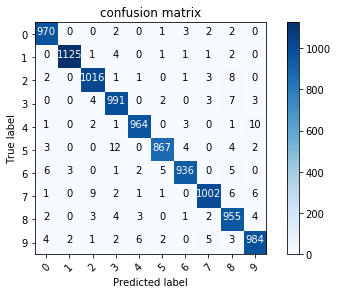

epoch 37, minibatch 32000, OB_Fun error 0.048499,test error 1.900000,Best test error 1.900000  %
Evaluating: epoch 37, minibatch 40000 %
Evaluating: epoch 37, minibatch 48000 %
Evaluating: epoch 38, minibatch 0 %
Evaluating: epoch 38, minibatch 8000 %
Evaluating: epoch 38, minibatch 16000 %
Evaluating: epoch 38, minibatch 24000 %
Evaluating: epoch 38, minibatch 32000 %
Evaluating: epoch 38, minibatch 40000 %
Evaluating: epoch 38, minibatch 48000 %
Evaluating: epoch 39, minibatch 0 %
Evaluating: epoch 39, minibatch 8000 %
Evaluating: epoch 39, minibatch 16000 %
Evaluating: epoch 39, minibatch 24000 %
Evaluating: epoch 39, minibatch 32000 %
Evaluating: epoch 39, minibatch 40000 %
Evaluating: epoch 39, minibatch 48000 %
Evaluating: epoch 40, minibatch 0 %
Evaluating: epoch 40, minibatch 8000 %
Evaluating: epoch 40, minibatch 16000 %
Evaluating: epoch 40, minibatch 24000 %
Evaluating: epoch 40, minibatch 32000 %
Evaluating: epoch 40, minibatch 40000 %
Evaluating: epoch 40, minibatch 48000 

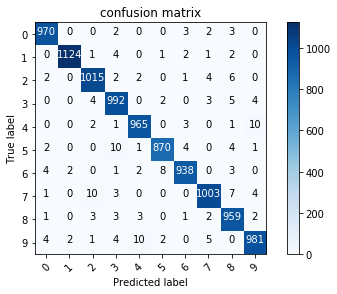

epoch 40, minibatch 48000, OB_Fun error 0.030816,test error 1.830000,Best test error 1.830000  %
Evaluating: epoch 41, minibatch 0 %
Evaluating: epoch 41, minibatch 8000 %
Evaluating: epoch 41, minibatch 16000 %
Evaluating: epoch 41, minibatch 24000 %
Evaluating: epoch 41, minibatch 32000 %
Evaluating: epoch 41, minibatch 40000 %
Evaluating: epoch 41, minibatch 48000 %
Evaluating: epoch 42, minibatch 0 %
Evaluating: epoch 42, minibatch 8000 %
Evaluating: epoch 42, minibatch 16000 %
Evaluating: epoch 42, minibatch 24000 %
Evaluating: epoch 42, minibatch 32000 %
Evaluating: epoch 42, minibatch 40000 %
Evaluating: epoch 42, minibatch 48000 %
Evaluating: epoch 43, minibatch 0 %
Evaluating: epoch 43, minibatch 8000 %
Evaluating: epoch 43, minibatch 16000 %
Evaluating: epoch 43, minibatch 24000 %
Evaluating: epoch 43, minibatch 32000 %
Evaluating: epoch 43, minibatch 40000 %
Evaluating: epoch 43, minibatch 48000 %
Evaluating: epoch 44, minibatch 0 %
Evaluating: epoch 44, minibatch 8000 %
Eva

In [19]:
#This is the entry point for the code. Here you can define input files and hyperparameters.To run this
# you need to compile all above functions defined in notebook---------------------------------------
# functions needed to compile: plot_confusion_matrix,get_minibatch_grad,sgd,forward,getPredictionError,make_network
# To compile click into function block and press cltr+ enter

import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit
import numpy as np
from numpy import linalg as LA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Load Data (Comment one method) ------------------------------------------------------
#Option:1  load data from csv file -------------------------------------------------- 
# provide path for train, validation and test data------------------------------------
# Last column of each file should be lables. lables could start from 0 or 1-----------
'''pathTrain='path of training data'
pathVal='path of validation data'
pathTest='path of test data'

train=np.genfromtxt(pathTrain, delimiter=',')
val=np.genfromtxt(pathVal, delimiter=',')
test=np.genfromtxt(pathTest, delimiter=',')

X_train=train[:,0:train.shape[1]-2]
y_train = train[:,train.shape[1]-1]
X_test=test[:,0:test.shape[1]-2]
y_test = test[:,test.shape[1]-1]
X_Val=val[:,0:val.shape[1]-2]
y_Val= val[:,val.shape[1]-1]'''


#Option:2  load pickled Data -------------------------------------------------- 
# train set, val set and test set from pickled data----------------------------
# put pickled file in the same directory where code is-------------------------
# this examle uses mnist pickled file for demo. Pickled file is available with is code
# data source for mnist: deeplearning.net/data/mnist/mnist.pkl.gz
with gzip.open('mnist.pkl.gz', 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
X_train, y_train = train_set
X_test, y_test = test_set
X_Val, y_Val = valid_set  


n_feature=X_train.shape[1] # get number of features in data

#preprocessing (Comment one option)---------------------------------------
#Option 1: Center to the mean and scale to unit variance
'''scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)
X_Val = scaler.transform(X_Val)'''

#Option 2: Scale between -1 and 1------------------------
'''scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(-1, 1))
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X_Val=scaler.transform(X_Val)'''
# end preprocessing---------------------------------------
#in example case we are not doing any preprocessing as data is already normalized
#get if lables are 0 based or 1 based. if they are 1 based make them 0 based------
if np.amin(y_train)==0:
    n_classes=int(np.amax(y_train)+1)
else:
    n_classes=int(np.amax(y_train))
    y_train=y_train-1
    y_test=y_test-1
    y_Val=y_Val-1

# end section---------------------------------------------------------------------
# set algorithm hyperparameters----------------------------------------------------
n_models=n_classes # twin neural network creates number of models= number of classes
minibatch_size = 50 # mini batch size
n_hidden=120 # number of neurons in hidden layer
n_planes=6 # number of planes in the final layer as per twin neural network topography
n_iter = 50 # total iterations
lr=0.01 # learning rate of algorithm
samples_eval=8000 # number of samples after which val error to be calculated
# end set algorithm hyperparameters----------------------------------------------------

#Create model dictionary and initialize weights---------------------------------------
model=[]
for k in range(n_models):
    model.append(make_network(n_hidden,n_planes,n_feature))
#End Create model dictionary and initialize weights-------------------------------------

%matplotlib inline
# Training Starts here------------------------------------------------------------------
#calls function sgd and passes parameters-----------------------------------------------
model = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr,samples_eval)
# Training ends here------------------------------------------------------------------
